In [1]:
# by Medvedeva NA
# medvedeva.n.box@yandex.ru

### ``Маркетинг. Запуск Акции. A/B-тест посадочной страницы``
*маркер лучшего варианта - количество покупок*

1. Первичный анализ датасета
   - приведение столбцов к корректным типам данных
   - проверка периодов по группам (визуализация)
   - проверка корректности распределения участников теста
   - проверка различия в группах
   - проверка пересечения аудитории в группах
   - расчет по группам (колич. пользователей, колич. покупок, выручка, конверсия, средний чек)
   - как распределяются суммы покупок (визуализация)
   - первичные выводы
2. Рассчет кумулятивных метрик
   - график конверсии в группах по дням
   - график среднего чека в группах по дням
   - график кумулятивных метрик по конверсии и по среднему чеку
   - выводы
3. Статистическая проверка гипотез:
   - о равенстве конверсии
   - о равенстве выручки
   - о равенстве средних чеков по дням
   - выводы


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
# from google.colab import drive # подкл. гугл диска к колабу
# drive.mount('/content/gdrive')

ab_data = pd.read_csv('ab_data.csv', sep=',')  # 294 478 : исходные 100% визитов
ab_data.user_id.nunique()                      # 290 584 : исходные 100% уник.пользователей
ab_data = ab_data.drop(['Unnamed: 0'], axis=1)            # убрать лишние столбцы
dt = pd.to_datetime(ab_data['date'], format='%Y-%m-%d')   # date в формат datetime
ab_data['date'] = dt
ab_data.date.describe()                                   # 2 - 24 января 2021

 
# 1. Разделение на группы. Проверка группы на корректность
gr_a = ab_data.query('group == "A"').reset_index().sort_values(by='index')   # исх.группа A : 147 202 визитов (50%) : 146 195 уник.пользователей
gr_b = ab_data.query('group == "B"').reset_index().sort_values(by='index')   # исх.группа В : 147 276 визитов (50%) : 146 284 уник.пользователей

dupl_users = gr_a.merge(gr_b, on='user_id', how='inner')                     # пересечение групп А ∩ В = 1895 пользователей (5%)
# Вывод: Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей.

ids_dataset = set(ab_data.user_id)                                           # set {290 584} : исходные 100% уник.пользователей
ids_dupl_set = set(dupl_users.user_id)                                       # set {1895}
ids_dif = ids_dataset.difference(ids_dupl_set)                               # set {290 584} - set {1895} = set {288 689} : итоговые 100% уник.пользователей
ids_dif_df = pd.DataFrame(data = ids_dif, columns = ['user_id'])             # set в df

ab_data_dif = ab_data.merge(ids_dif_df, on='user_id', how='inner')            # 290 688 : итоговые 100% визитов (за вычетом 1895 пользователей)
ab_data_dif['revenue'] = ab_data_dif.price/1000000000 # сумма в млрд.(10*6)


# 2. Разделение на группы. За вычетом 5% пользователей {1895}
group_A = ab_data_dif.query('group == "A"').reset_index().sort_values(by='index')   # группа A : 145 307 визитов (50%) : 144 300 уник.пользователей
group_B = ab_data_dif.query('group == "B"').reset_index().sort_values(by='index')   # группа В : 145 381 визитов (50%) : 144 389 уник.пользователей
# Вывод: Разница в количестве сессий отличается менее, чем на 1%

# Маркировка групп стоимостей
def route_mark(row):
    if row==10000:
        return 'SPB'
    elif row==100000:
        return 'Thailand'
    elif row==60000:
        return 'Turkiye'
    elif row==150000:
        return 'Kamchatka'
    elif row==200000:
        return 'Maldives'
    else:
        'error'
ab_data_dif['route'] = ab_data_dif['price'].apply(route_mark) 
# display(group_A)


In [ ]:
#  Показатели конверсии(%) и среднего чека(AOV) по каждой группе
 
g1 = ab_data_dif.groupby(['group'])['user_id'].count().reset_index()
g2 = ab_data_dif.groupby(['group'])[['purchase', 'price']].sum().reset_index()
ab = g1.merge(g2, how = 'outer')

ab['AOV'] = round(ab['price']/ab['purchase'],2)
ab['CR_perc'] = round(ab['purchase']/ab['user_id']*100,2)
print('Вывод: Несмотря на то что в группе B было больше посетителей, (относительная) конверсия в группе B меньше на 1.16%. \nЗа счёт меньшей конверсии в группе B было меньше покупок, однако выручка группы B больше выручки группы A на 115230000 единиц, или 7.5%. \nБольшая выручка в группе B складывается за счёт того, что средний чек группы B выше среднего чека группы A')

display(ab)

In [ ]:
# Гистограмма по выручке для групп A и B

'''ab_data_dif.plot(
    y = ab_data_dif['revenue'],
    kind = 'hist',
    figsize = (3, 3),
    title = 'Выручка групп A и B',
    xlabel = 'группы',
    ylabel = 'выручка',
    fontsize = 10,
    rot=0);'''

prices_A = group_A.price.value_counts().reset_index()
prices_B = group_B.price.value_counts().reset_index()

ab_price = group_A.merge(group_B, how='outer', on='price', suffixes=('_A', '_B'))

display(ab_price, prices_A, prices_B)

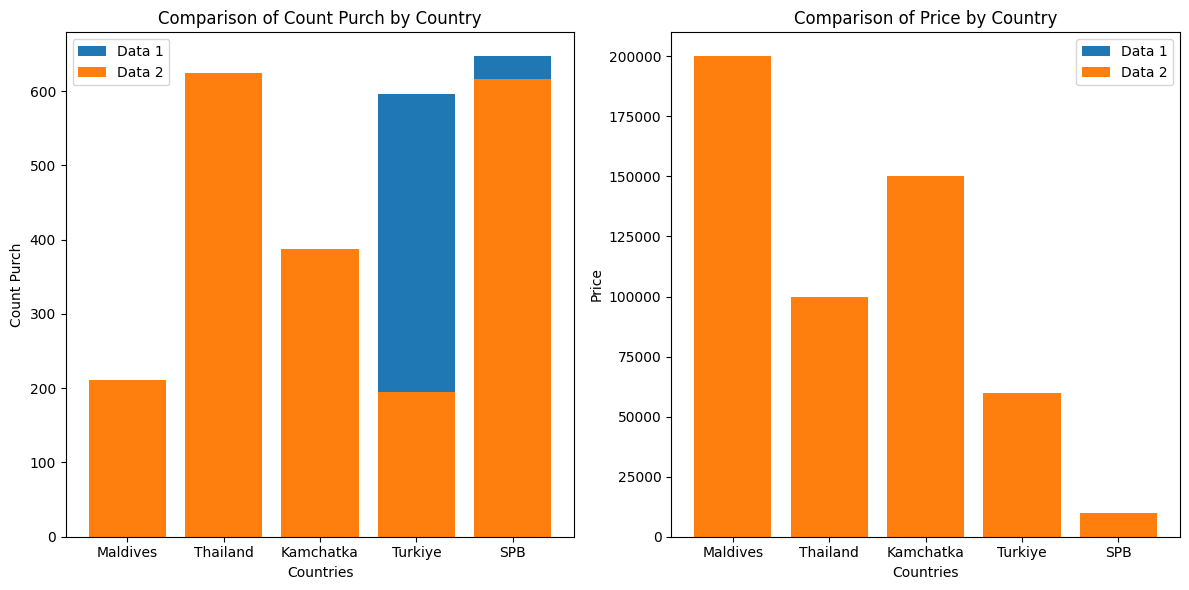

In [1]:
import matplotlib.pyplot as plt

data1 = {
    'Maldives': {'count_purch': 209, 'price': 200000.0},
    'Thailand': {'count_purch': 229, 'price': 100000.0},
    'Kamchatka': {'count_purch': 387, 'price': 150000.0},
    'Turkiye': {'count_purch': 596, 'price': 60000.0},
    'SPB': {'count_purch': 647, 'price': 10000.0}
}

data2 = {
    'Turkiye': {'count_purch': 195, 'price': 60000.0},
    'Maldives': {'count_purch': 211, 'price': 200000.0},
    'Kamchatka': {'count_purch': 388, 'price': 150000.0},
    'SPB': {'count_purch': 616, 'price': 10000.0},
    'Thailand': {'count_purch': 625, 'price': 100000.0}
}

countries = list(data1.keys())
count_purch1 = [data1[country]['count_purch'] for country in countries]
price1 = [data1[country]['price'] for country in countries]

count_purch2 = [data2[country]['count_purch'] for country in countries]
price2 = [data2[country]['price'] for country in countries]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(countries, count_purch1, label='Data 1')
plt.bar(countries, count_purch2, label='Data 2')
plt.xlabel('Countries')
plt.ylabel('Count Purch')
plt.title('Comparison of Count Purch by Country')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(countries, price1, label='Data 1')
plt.bar(countries, price2, label='Data 2')
plt.xlabel('Countries')
plt.ylabel('Price')
plt.title('Comparison of Price by Country')
plt.legend()

plt.tight_layout()
plt.show()